In [31]:
import yfinance as yf
import numpy as np
import pywt
import matplotlib.pyplot as plt
import pandas as pd

In [32]:
def modwt_decompose_pd(df: pd.DataFrame, column: str, wavelet='db1', level=None, norm=False, crop_days=14) -> pd.DataFrame:
    """
    Decompose a time series (Pandas DataFrame) into trend and noise components using SWT or MODWT-like decomposition.

    Args:
        df (pd.DataFrame): Input Pandas DataFrame with time series data.
        column (str): Column name to decompose.
        wavelet (str): Wavelet type (default: 'db1').
        level (int or None): Decomposition level (default: None).
        norm (bool): Whether to use MODWT-like normalization (default: False).
        crop_days (int): Number of data points to crop from the start of the series to avoid boundary effects (default: 10).

    Returns:
        pd.DataFrame: Pandas DataFrame with 'Trend' and 'Noise' columns, cropped to avoid boundary effects.
    """
    # Extract the series as a NumPy array
    series = df[column].to_numpy()

    # Symmetrize the data for non-dyadic lengths
    orig_len = len(series)
    padding_len = 2**int(np.ceil(np.log2(orig_len))) - orig_len
    sym_series = np.concatenate((series, series[-padding_len:][::-1])) if padding_len > 0 else series

    # Perform SWT (almost the same as MODWT when norm=True)
    coeffs = pywt.swt(sym_series, wavelet, level=level, norm=norm)

    # Separate the trend and noise components
    trend_coeffs = [coeff for coeff in coeffs]

    # Zero out all detail coefficients to retain the trend
    for i in range(len(trend_coeffs)):
        trend_coeffs[i] = (trend_coeffs[i][0], np.zeros_like(trend_coeffs[i][1]))

    # Reconstruct the trend using inverse SWT
    sym_trend = pywt.iswt(trend_coeffs, wavelet)
    trend = sym_trend[:orig_len]

    # Subtract trend from original to get the noise
    noise = series - trend

    # Crop the first `crop_days` points from trend and noise
    trend = trend[crop_days:]
    noise = noise[crop_days:]
    cropped_dates = df["Date"].iloc[crop_days:].reset_index(drop=True)

    # Create and return a Pandas DataFrame with trend and noise
    result = pd.DataFrame({
        "Date": cropped_dates,
        "Trend": trend,
        "Noise": noise
    })
    return result


In [33]:
# Fetch S&P 500 data
ticker = "SPY"
start_date = "2010-03-01"
end_date = "2018-03-15"
data = yf.download(ticker, start=start_date, end=end_date)
prices = data['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [34]:
# Renaming columns for simplicity
prices.reset_index(inplace=True)
prices.columns = ['Date', 'Adj Close']

In [35]:
# Decompose the series into trend and noise
results = modwt_decompose_pd(prices, column='Adj Close', level=4)

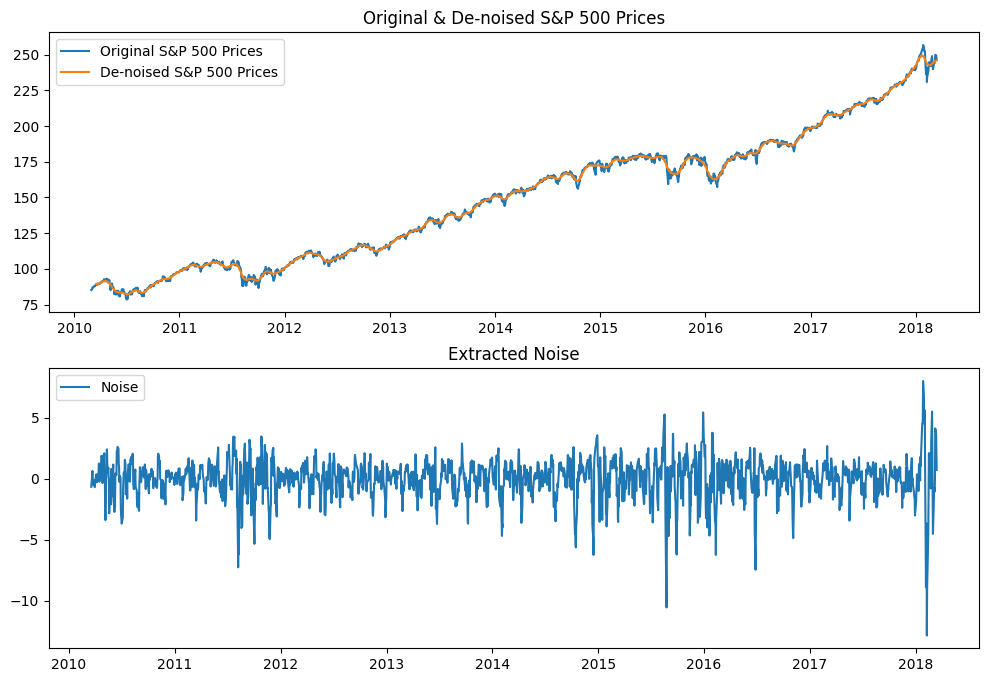

In [36]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# original & de-noised prices
axes[0].plot(prices['Date'], prices['Adj Close'], label='Original S&P 500 Prices')
axes[0].plot(results['Date'], results['Trend'], label='De-noised S&P 500 Prices')
axes[0].set_title('Original & De-noised S&P 500 Prices')
axes[0].legend()

# noise
axes[1].plot(results['Date'], results['Noise'], label='Noise')
axes[1].set_title('Extracted Noise')
axes[1].legend()

plt.tight_layout
plt.show()